In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PINN.European import EuropeanPINN
from PINN.utilities import V_BS, V_BS_CN

BS PDE
$$
\frac{\partial V}{\partial \tau}-\frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{\partial S^2}-r S \frac{\partial V}{\partial S}+r V=0.
$$

For European put option, we have initial and boundary conditions
$$
V(S, 0) = (K - S)^+, V(0, \tau) = Ke^{-r\tau}, V(\infty, \tau) = 0.
$$

For European options, we have analytic solutions
$$
V(S, \tau)=K e^{-r \tau}\left(1-N\left(d_2\right)\right)+\left(N\left(d_1\right)-1\right) S,
$$
where
$$
d_1=\frac{\log (S / K)+\left(r+0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}, d_2=\frac{\log (S / K)+\left(r-0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}.
$$



In [2]:
# load data
ib = torch.load('data/european_put_ib.pt')
pde = torch.load('data/european_put_pde.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']
S_pde, tau_pde = pde['S'], pde['tau']

# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K

TRAIN = False

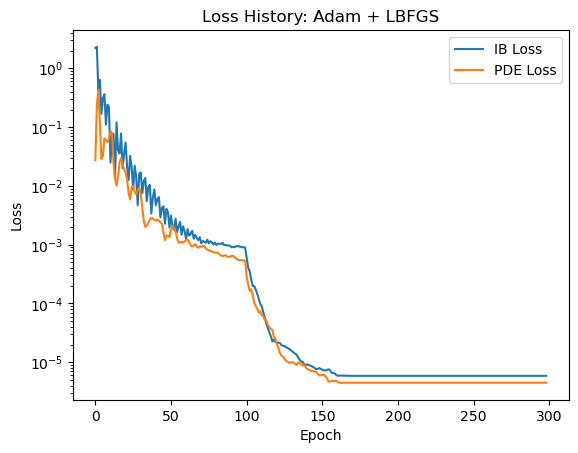

In [3]:
if TRAIN:
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )

    model = EuropeanPINN(nn, K, T, r, sigma, S_inf)

    # First train with Adam for 100 epochs
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=100, optimizer='adam', lr=1e-1)
    # Then train with L-BFGS for 200 epochs
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=200, optimizer='lbfgs')
    # save model
    torch.save(model, 'models/european_put_adam_lbfgs.pt')

model = torch.load('models/european_put_adam_lbfgs.pt')
model.plot_loss(data=False, save=True, title='Loss History: Adam + LBFGS')

/Users/liyiyan/Documents/vscode/Option-Pricing-Using-Physics-Informed-Neural-Networks/PINN/utilities.py:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))


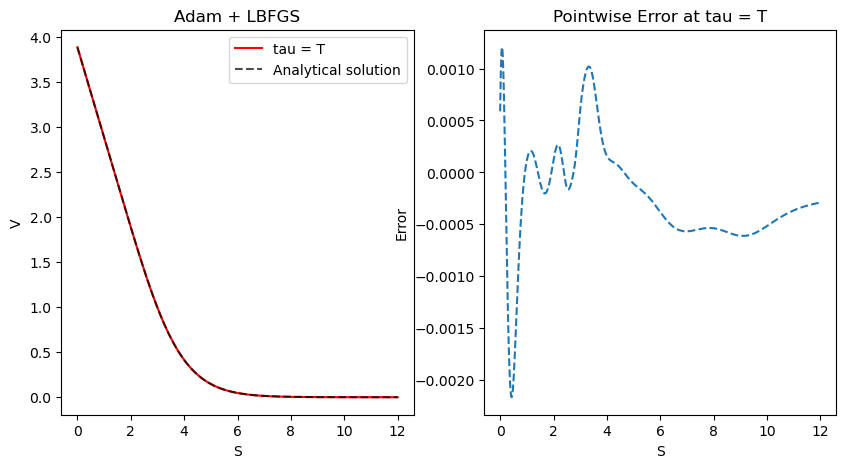

In [4]:
# load model
model = torch.load('models/european_put_adam_lbfgs.pt')

# # plot
# S_plot = torch.linspace(0, 10, 1000)
# tau_plot = torch.linspace(0, T, 1000)
# S_plot, tau_plot = torch.meshgrid(S_plot, tau_plot)
# V_plot = model(S_plot.reshape(-1, 1), tau_plot.reshape(-1, 1)).detach().reshape(1000, 1000)
# # 3d plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(S_plot.numpy(), tau_plot.numpy(), V_plot.numpy())
# ax.set_xlabel('S')
# ax.set_ylabel('tau')
# ax.set_zlabel('V')
# plt.show()

# plot tau = T
S_plot = torch.linspace(0, S_inf, 1000)
V_plot = model(S_plot.reshape(-1, 1), (torch.ones(1000, 1))*T).reshape(-1).detach()
V_true = V_BS(S_plot.detach().numpy(), tau=T, K=K, r=r, sigma=sigma, type='put')
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(S_plot, V_plot, label='tau = T', c='red')
plt.plot(S_plot, V_true, label='Analytical solution', ls='--', c='black', alpha=0.7)
plt.xlabel('S')
plt.ylabel('V')
plt.title('Adam + LBFGS')
plt.legend()

# plot pointwise error at tau = T
plt.subplot(122)
plt.plot(S_plot, V_plot - V_true, ls='--')
plt.xlabel('S')
plt.ylabel('Error')
plt.title('Pointwise Error at tau = T')

plt.savefig('./data/images/european_put_adam_lbfgs.pdf')
plt.show()

/Users/liyiyan/Documents/vscode/Option-Pricing-Using-Physics-Informed-Neural-Networks/PINN/utilities.py:7: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))


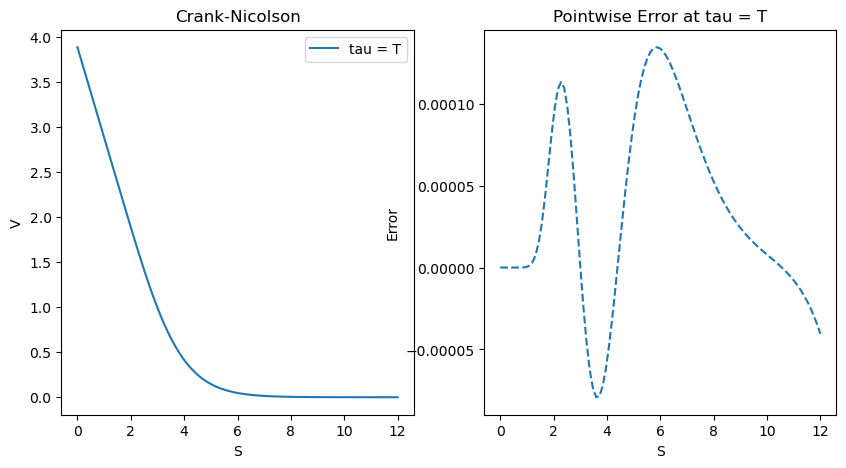

In [5]:
V, S, t = V_BS_CN(100, 100, T, K, sigma, r, S_inf)

# plot CN solution at tau = T
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(S, V[-1, :], label='tau = T')
plt.xlabel('S')
plt.ylabel('V')
plt.title('Crank-Nicolson')
plt.legend()

# plot pointwise error at tau = T
plt.subplot(122)
V_true = V_BS(S, tau=T, K=K, r=r, sigma=sigma, type='put')
plt.plot(S, V[-1, :] - V_true, ls='--')
plt.xlabel('S')
plt.ylabel('Error')
plt.title('Pointwise Error at tau = T')

plt.savefig('./data/images/european_put_cn.pdf')
plt.show()